# Diving Into WFI TVAC Bright Star Test Data

## Kernel Information and Read-Only Status

To run this notebook, please select the "Roman Calibration" kernel at the top right of your window.

This notebook is read-only. You can run cells and make edits, but you must save changes to a different location. We recommend saving the notebook within your home directory, or to a new folder within your home (e.g. <span style="font-variant:small-caps;">file > save notebook as > my-nbs/nb.ipynb</span>). Note that a directory must exist before you attempt to add a notebook to it.

<font color='red'>Note: In order for this notebook to run on the Nexus, please select the medium size server, as it requires >26 GB of memory to stream and process the data files used here.</font>

## Imports
 Libraries used
- *romancal* for running the processing pipeline
- *roman_datamodels* for opening Roman WFI ASDF files
- *asdf* for opening Roman WFI ASDF files
- *os* for checking if files exist
- *copy* for making copies of Python objects
- *s3fs* for streaming files from an S3 bucket

## Introduction
In Fall 2023 and Spring 2024, the Wide Field Instrument (WFI) underwent thermal vacuum (TVAC) at BAE Systems in Boulder, Colorado to collect performance and trending data in a flight-like environment. To learn more about TVAC, please visit the [RDox pages on the WFI Ground Testing Campaigns](https://roman-docs.stsci.edu/roman-instruments-home/wfi-imaging-mode-user-guide/wfi-detectors/detector-performance/wfi-ground-testing-campaigns#WFIGroundTestingCampaigns-WFI_Testing).

As part of the TVAC campaign, the WFI Bright Star Saturation test was conducted to characterize how WFI Sensor Chip Assemblies (SCAs) respond to saturation from a wide range of bright, in-focus point sources, similar to those expected during Roman's science surveys. A telescope simulator was used to project nine simulated point sources with magnitudes ranging from ~4 to ~18 mag through the F146 filter, onto a grid of locations on SCAs 4 and 11. Note that due to the characteristics of the telescope simulator and ground test setup, the acquired data do not reproduce the optics of the observatory.

In this notebook we explore a subset of the point source data. We apply a non-complete set of calibrations with the Roman WFI science calibration pipeline RomanCal (Python package name `romancal`) and visualize the results. 

## Tutorial Data
In this tutorial, we use L1 WFI test data files stored in the Nexus S3 bucket. See the [Data Discovery and Access](../data_discovery_and_access/data_discovery_and_access.ipynb) and [Exposure Pipeline](../exposure_pipeline/exposure_pipeline.ipynb) tutorials for more information on how to pull data and run Romancal.

In [1]:
%matplotlib inline
import numpy as np
from scipy.signal import convolve2d
import math
import asdf
import os
import copy
import roman_datamodels as rdm
from roman_datamodels.dqflags import pixel as dqflags
from romancal.saturation import SaturationStep
from roman_datamodels.datamodels import SaturationRefModel
import matplotlib.pyplot as plt
import s3fs
import romancal
from romancal.pipeline import ExposurePipeline

## Pull the data
We will ingest data corresponding to:
* a magnitude 4 (approximately) point source imaged through F146 on SCA 11
* three subsequent darks.

In [2]:
# Utility function to open a given asdf file
def open_asdf_datamodel(asdf_uri: str, anon: bool = True):
    """
    Open an ASDF file from S3 or locally and return a Roman datamodel
    """
    if asdf_uri.startswith("s3://"):
        fs = s3fs.S3FileSystem(anon=anon)
        with fs.open(asdf_uri, "rb") as fb:
            with asdf.open(fb) as af:
                return rdm.open(af).copy()
    else:
        with open(asdf_uri, "rb") as fb:
            with asdf.open(fb) as af:
                return rdm.open(af).copy()

Below, we point to a particular "activity" which corresponds to a given type of data collection. Typically, an activity refers to a set of exposures with the same attributes like commanded flux, filter, location and is constrained by the test planning software used for these ground tests. Please refer to this [table](activity_table.md) to see the mapping between activities in the test and type of collected test data.

In [3]:
# This is hard-coded
# Another option is to run a search for the right activity/mag/SCA.
Mag = 4
SCA = 11
WFI_TAG = f'WFI{SCA:02d}'
asdf_dir_uri = 's3://stpubdata/roman/nexus/tvac/'
base = asdf_dir_uri + 'OTP00651_BrightStar_TV2b_R1_MCEB/'

# Illuminated image
# To find the full filename(s), you can perform a list command (`ls`) on the directory path that includes the activity number (e.g., `Activity_22`)
asdf_file_uri_illum = base + f'Activity_22/TVAC2_TOHOTQUAL_WFISAT_20240506204523_{WFI_TAG}_uncal.asdf'

dm_illum = open_asdf_datamodel(asdf_file_uri_illum, anon=True)

# Final 3 dark exposures collected in this test
asdf_file_uri_d1 = base + f'Activity_40/TVAC2_TOHOTQUAL_WFISAT_20240506225304_{WFI_TAG}_uncal.asdf'
asdf_file_uri_d2 = base + f'Activity_40/TVAC2_TOHOTQUAL_WFISAT_20240506225611_{WFI_TAG}_uncal.asdf'
asdf_file_uri_d3 = base + f'Activity_40/TVAC2_TOHOTQUAL_WFISAT_20240506225917_{WFI_TAG}_uncal.asdf'
dm16 = open_asdf_datamodel(asdf_file_uri_d1, anon=True)
dm17 = open_asdf_datamodel(asdf_file_uri_d2, anon=True)
dm18 = open_asdf_datamodel(asdf_file_uri_d3, anon=True)

# Close the files afterward
dm_illum.close(); dm16.close(); dm17.close(); dm18.close()

In [4]:
# Type of datamodel and info
print(type(dm_illum))
dm_illum.info()

<class 'roman_datamodels.datamodels._datamodels.TvacModel'>
root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 3.2.0
├─history (dict)
│ └─extensions (list)
│   ├─[0] (ExtensionMetadata) ...
│   ├─[1] (ExtensionMetadata) ...
│   └─[2] (ExtensionMetadata) ...
└─roman (Tvac) # Schema for the TVAC Test Data

  ├─meta (dict) ...
  ├─data (Quantity) # Science data, including the border reference pixels.
  ├─amp33 (Quantity) # Amp 33 reference pixel data.
  ├─amp33_reset_reads (Quantity) # Amp 33 reset reads performed before integration data.
  ├─amp33_reference_read (Quantity) # Amp 33 reference reads that can be subtracted from the amp33 ramp data (truncated)
  ├─guidewindow (Quantity) # Guide window data.
  ├─reference_read (Quantity) # Reference read that can be subtracted from ramp, if present.
  ├─reset_reads (Quantity) # Reset reads performed before the ramp int

## Calibrate the data
We will run the illuminated data through Romancal. In particular we apply data quality initialization, saturation detection, reference pixel correction, and linearity. The rest of the steps are skipped. We do not process the darks in this way to save computing time and memory for this tutorial.

In [5]:
# Put datamodels in a dictionary for utility
exps = {
    "illum": dm_illum,
    "exp16": dm16,
    "exp17": dm17,
    "exp18": dm18,
}

# Pipeline options
# Add more to change defaults on other steps and can also add an output directory
pipe_kwargs = {
    "save_results": False,
    "steps": {
        "dark_current": {"skip": True},
        "rampfit": {"skip": True},
        "assign_wcs": {"skip": True},
        "flatfield": {"skip": True},
        "photom": {"skip": True},
        "source_catalog": {"skip": True},
        "tweakreg": {"skip": True},
    },
}

# Dictionary to save calibrated outputs
results = {}
for tag, f in exps.items():
    try:
        res = ExposurePipeline.call(f, **pipe_kwargs)
        results[tag] = res
        # Close model if it does not need to be stored in memory
        # f.close()
        # Adding a break to only do the illuminated exposure to limit computing time and storage space
        break 
    except Exception as e:
        print(f"[{tag}] pipeline failed: {e}")
        results[tag] = None
        break

2025-12-11 19:29:20,958 - CRDS - ERROR -  Error determining best reference for 'pars-dqinitstep'  =   No match found.


2025-12-11 19:29:20,959 - CRDS - ERROR -  Error determining best reference for 'pars-saturationstep'  =   No match found.


2025-12-11 19:29:20,961 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =   No match found.


2025-12-11 19:29:20,962 - CRDS - ERROR -  Error determining best reference for 'pars-linearitystep'  =   No match found.


2025-12-11 19:29:20,963 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-12-11 19:29:20,964 - CRDS - ERROR -  Error determining best reference for 'pars-rampfitstep'  =   No match found.


2025-12-11 19:29:20,965 - CRDS - ERROR -  Error determining best reference for 'pars-assignwcsstep'  =   No match found.


2025-12-11 19:29:20,966 - CRDS - ERROR -  Error determining best reference for 'pars-flatfieldstep'  =   No match found.


2025-12-11 19:29:20,967 - CRDS - ERROR -  Error determining best reference for 'pars-photomstep'  =   No match found.


2025-12-11 19:29:20,968 - CRDS - ERROR -  Error determining best reference for 'pars-sourcecatalogstep'  =   Unknown reference type 'pars-sourcecatalogstep'


2025-12-11 19:29:20,969 - CRDS - ERROR -  Error determining best reference for 'pars-tweakregstep'  =   No match found.


2025-12-11 19:29:20,970 - CRDS - ERROR -  Error determining best reference for 'pars-exposurepipeline'  =   No match found.


2025-12-11 19:29:20,977 - stpipe.ExposurePipeline - INFO - ExposurePipeline instance created.


2025-12-11 19:29:20,978 - stpipe.ExposurePipeline.dq_init - INFO - DQInitStep instance created.


2025-12-11 19:29:20,978 - stpipe.ExposurePipeline.saturation - INFO - SaturationStep instance created.


2025-12-11 19:29:20,979 - stpipe.ExposurePipeline.refpix - INFO - RefPixStep instance created.


2025-12-11 19:29:20,980 - stpipe.ExposurePipeline.linearity - INFO - LinearityStep instance created.


2025-12-11 19:29:20,981 - stpipe.ExposurePipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-12-11 19:29:20,982 - stpipe.ExposurePipeline.rampfit - INFO - RampFitStep instance created.


2025-12-11 19:29:20,983 - stpipe.ExposurePipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-12-11 19:29:20,983 - stpipe.ExposurePipeline.flatfield - INFO - FlatFieldStep instance created.


2025-12-11 19:29:20,984 - stpipe.ExposurePipeline.photom - INFO - PhotomStep instance created.


2025-12-11 19:29:20,985 - stpipe.ExposurePipeline.source_catalog - INFO - SourceCatalogStep instance created.


2025-12-11 19:29:20,986 - stpipe.ExposurePipeline.tweakreg - INFO - TweakRegStep instance created.


2025-12-11 19:29:21,139 - stpipe.ExposurePipeline - INFO - Step ExposurePipeline running with args (<roman_datamodels.datamodels._datamodels.TvacModel object at 0x7fa8b2810550>,).


2025-12-11 19:29:21,151 - stpipe.ExposurePipeline - INFO - Step ExposurePipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .asdf
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: cal
  search_output_file: True
  input_dir: ''
  save_l1_wcs: False
  steps:
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .asdf
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    saturation:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .asdf
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    refpix:
      pre_hooks: []
      

2025-12-11 19:29:21,153 - stpipe.ExposurePipeline - INFO - Prefetching reference files for dataset: 'TVAC2_TOHOTQUAL_WFISAT_20240506204523_WFI11_uncal.asdf' reftypes = ['linearity', 'mask', 'refpix', 'saturation']


2025-12-11 19:29:21,155 - stpipe.ExposurePipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/roman/wfi/roman_wfi_linearity_0054.asdf'.


2025-12-11 19:29:21,156 - stpipe.ExposurePipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/roman/wfi/roman_wfi_mask_0023.asdf'.


2025-12-11 19:29:21,156 - stpipe.ExposurePipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/roman/wfi/roman_wfi_refpix_0007.asdf'.


2025-12-11 19:29:21,156 - stpipe.ExposurePipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/roman/wfi/roman_wfi_saturation_0030.asdf'.


2025-12-11 19:29:21,157 - romancal.pipeline.exposure_pipeline - INFO - Starting Roman exposure calibration pipeline ...


2025-12-11 19:29:21,301 - stpipe.ExposurePipeline.dq_init - INFO - Step dq_init running with args (<roman_datamodels.datamodels._datamodels.TvacModel object at 0x7fa8b2810550>,).


2025-12-11 19:29:22,442 - romancal.dq_init.dq_init_step - INFO - Flagging rows from: -999999 to -999829 as affected by guide window read


2025-12-11 19:29:22,529 - stpipe.ExposurePipeline.dq_init - INFO - Step dq_init done


2025-12-11 19:29:22,725 - stpipe.ExposurePipeline.saturation - INFO - Step saturation running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7fa8b2757770>,).


2025-12-11 19:29:22,729 - romancal.saturation.saturation_step - INFO - Using SATURATION reference file: /home/runner/crds_cache/references/roman/wfi/roman_wfi_saturation_0030.asdf


2025-12-11 19:29:29,457 - stcal.saturation.saturation - INFO - Detected 93159 saturated pixels


2025-12-11 19:29:29,912 - stcal.saturation.saturation - INFO - Detected 868 A/D floor pixels


2025-12-11 19:29:29,938 - stpipe.ExposurePipeline.saturation - INFO - Step saturation done


2025-12-11 19:29:30,958 - stpipe.ExposurePipeline.refpix - INFO - Step refpix running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7fa8b2757770>,).


2025-12-11 19:30:00,563 - stpipe.ExposurePipeline.refpix - INFO - Step refpix done


2025-12-11 19:30:00,724 - stpipe.ExposurePipeline.linearity - INFO - Step linearity running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7fa8b2757770>,).


2025-12-11 19:30:00,729 - romancal.linearity.linearity_step - INFO - Using LINEARITY reference file: /home/runner/crds_cache/references/roman/wfi/roman_wfi_linearity_0054.asdf


2025-12-11 19:30:09,595 - stpipe.ExposurePipeline.linearity - INFO - Step linearity done


2025-12-11 19:30:09,799 - stpipe.ExposurePipeline.rampfit - INFO - Step rampfit running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7fa8b2757770>,).


2025-12-11 19:30:09,799 - stpipe.ExposurePipeline.rampfit - INFO - Step skipped.


2025-12-11 19:30:10,043 - stpipe.ExposurePipeline.dark_current - INFO - Step dark_current running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7fa8b2757770>,).


2025-12-11 19:30:10,043 - stpipe.ExposurePipeline.dark_current - INFO - Step skipped.


2025-12-11 19:30:10,270 - stpipe.ExposurePipeline.assign_wcs - INFO - Step assign_wcs running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7fa8b2757770>,).


2025-12-11 19:30:10,271 - stpipe.ExposurePipeline.assign_wcs - INFO - Step skipped.


2025-12-11 19:30:10,463 - stpipe.ExposurePipeline.flatfield - INFO - Step flatfield running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7fa8b2757770>,).


2025-12-11 19:30:10,464 - stpipe.ExposurePipeline.flatfield - INFO - Step skipped.


2025-12-11 19:30:10,614 - stpipe.ExposurePipeline.photom - INFO - Step photom running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7fa8b2757770>,).


2025-12-11 19:30:10,615 - stpipe.ExposurePipeline.photom - INFO - Step skipped.


2025-12-11 19:30:10,773 - stpipe.ExposurePipeline.source_catalog - INFO - Step source_catalog running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7fa8b2757770>,).


2025-12-11 19:30:10,774 - stpipe.ExposurePipeline.source_catalog - INFO - Step skipped.


2025-12-11 19:30:10,958 - stpipe.ExposurePipeline.tweakreg - INFO - Step tweakreg running with args (<romancal.datamodels.library.ModelLibrary object at 0x7fa8b27556a0>,).


2025-12-11 19:30:10,959 - stpipe.ExposurePipeline.tweakreg - INFO - Step skipped.


2025-12-11 19:30:10,960 - romancal.pipeline.exposure_pipeline - INFO - Roman exposure calibration pipeline ending...


2025-12-11 19:30:10,961 - stpipe.ExposurePipeline - INFO - Step ExposurePipeline done


### Optional: Super Bias from darks (diagnostic only — not applied)
Data reductions usually include a step to compute and remove a superbias. This is a per-pixel intercept image typically obtained by fitting each pixel's ramp with a linear function and taking the intercept. These intercepts can be combined across multiple dark exposures to increase the signal to noise. We do not apply it in this tutorial because the Improved Roman Reference Correction (IRRC) step applied earlier should remove the bias offsets.

In [6]:
# Quick function over chunks to determine the per-pixel biases 
def bias_intercept_from_cube(cube, drop_first=True, chunk=(512, 512), out_dtype=np.float32):
    """
    Compute per-pixel intercept (bias) from a cube shaped (N, rows, cols),
    fitting y(t) = a + b t across frames for each pixel, using chunks.

    Parameters
    ----------
    cube : np.ndarray
        Array with shape (N, rows, cols).
    drop_first : bool
        If True, ignore frame 0 and fit frames 1..N-1.
    chunk : (int, int)
        Chunk size (rows, cols).
    out_dtype : np.dtype
        Output dtype for the bias image.

    Returns
    -------
    B : np.ndarray
        Bias image (rows, cols) as out_dtype.
    """
    cube = np.asarray(cube)  # (N, H, W)
    N_total, rows, cols = cube.shape
    start = 1 if drop_first else 0
    t = np.arange(start, N_total, dtype=np.float64)
    n = t.size
    if n < 2:
        raise ValueError("Need at least 2 frames (after dropping reset) to fit a line.")

    sum_t  = t.sum()
    sum_t2 = (t * t).sum()
    den = n * sum_t2 - sum_t * sum_t
    if den == 0:
        raise RuntimeError("Degenerate time vector; cannot fit.")

    B = np.empty((rows, cols), dtype=out_dtype)

    rt, ct = chunk
    for r0 in range(0, rows, rt):
        r1 = min(rows, r0 + rt)
        for c0 in range(0, cols, ct):
            c1 = min(cols, c0 + ct)

            # Load tile across all frames (avoid Python loops); keep memory modest with float32
            arr = cube[start:, r0:r1, c0:c1].astype(np.float32, copy=False)  # (n, rt', ct')

            # Accumulate sums (float64 math for accuracy)
            sY  = arr.sum(axis=0, dtype=np.float64) # Sum(Y)
            sTY = np.tensordot(t, arr, axes=(0, 0)) # Sum(T * Y)

            slope = (n * sTY - sum_t * sY) / den                              # b
            intercept = (sY - slope * sum_t) / n                              # a

            B[r0:r1, c0:c1] = intercept.astype(out_dtype, copy=False)

    return B

Now compute the bias for each of the three dark exposures, stack them, and plot the resulting "superbias." These darks were collected as the final three exposures of a series of 18 55-frame darks collected after the bright source images.

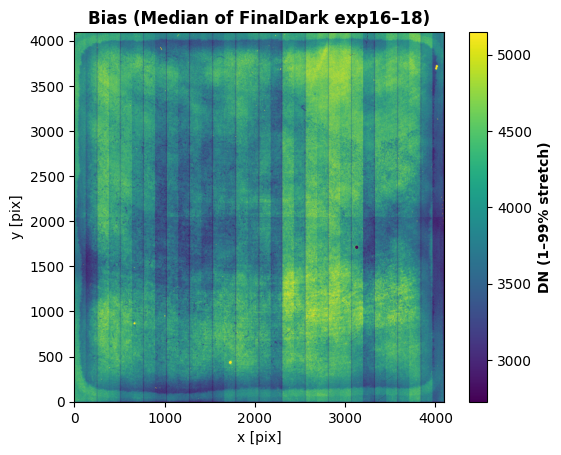

In [7]:
B16 = bias_intercept_from_cube(dm16.data, drop_first=True, chunk=(512, 512), out_dtype=np.float32)
B17 = bias_intercept_from_cube(dm17.data, drop_first=True, chunk=(512, 512), out_dtype=np.float32)
B18 = bias_intercept_from_cube(dm18.data, drop_first=True, chunk=(512, 512), out_dtype=np.float32)

# Combine into a "superbias"
stack    = np.stack([B16, B17, B18], axis=0)        # (3, H, W)
B_median = np.nanmedian(stack, axis=0).astype(np.float32)
B_mean   = np.nanmean(stack, axis=0).astype(np.float32)

# Visualization of the superbias
vmin, vmax = np.nanpercentile(B_median, [1, 99])
plt.imshow(B_median, vmin=vmin, vmax=vmax, origin="lower")
plt.title("Bias (Median of FinalDark exp16–18)", fontweight="bold", fontsize=12)
cbar = plt.colorbar(); cbar.set_label("DN (1–99% stretch)", fontweight="bold")
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")

plt.show()

We can verify that the Romancal refpix step was indeed applied. If not, then we can subtract the superbias with

`dm_cube = np.float32(results["illum"].data) - B_median[None, :, :]`

and continue to the next section.

In [8]:
# Check to see if the refpix step was indeed completed. If so, then we do not need
# to apply another bias.
cal = getattr(results["illum"].meta, "cal_step", None)
print("The refpix step is", getattr(cal, "refpix", None))

The refpix step is COMPLETE


## Make  plots
We will first look at the signal in three arbitary frames to see how the signal builds with time.

frame 2: 2nd=-14.4, 98th=80.5


frame 27: 2nd=-1.38, 98th=1.99e+03


frame 54: 2nd=10, 98th=4.03e+03


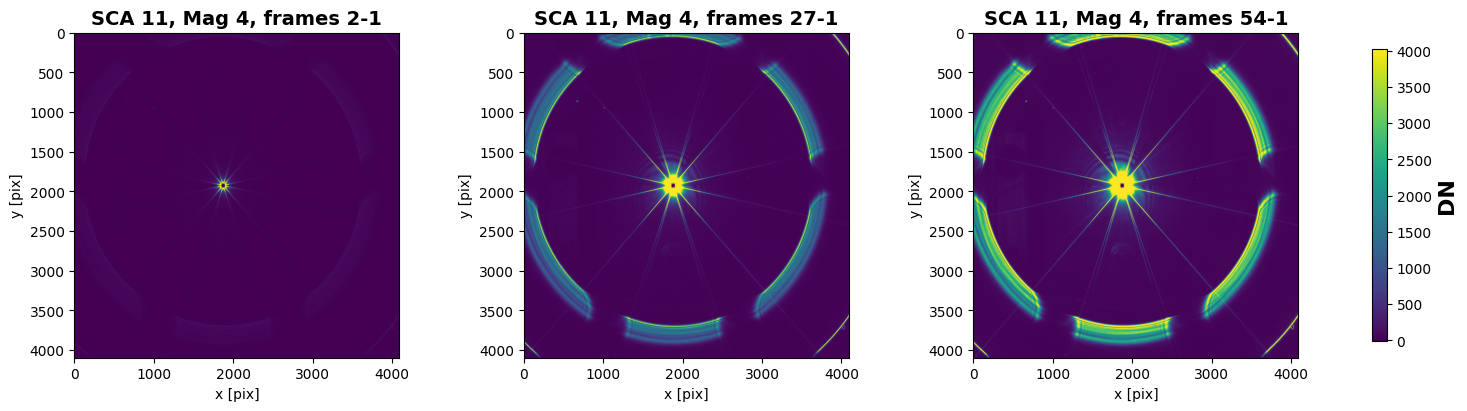

In [9]:
dm_cube = results["illum"].data
frames = [2, 27, 54]
baseline_frame = 1

# Compute per-frame differences and percentiles
diffs, vmins, vmaxs = [], [], []
for nframe in frames:
    d = dm_cube[nframe] - dm_cube[baseline_frame]
    diffs.append(d)
    vmin_i = np.percentile(d, 2)
    vmax_i = np.percentile(d, 98)
    vmins.append(vmin_i)
    vmaxs.append(vmax_i)
    print(f"frame {nframe}: 2nd={vmin_i:.3g}, 98th={vmax_i:.3g}")

# Plotting
vmin = min(vmins)
vmax = max(vmaxs)
fig, axes = plt.subplots(1, len(frames), figsize=(5*len(frames), 4), constrained_layout=True)
if len(frames) == 1:
    axes = [axes]

im = None
for ax, nframe, d in zip(axes, frames, diffs):
    im = ax.imshow(d, vmin=vmin, vmax=vmax)
    ax.set_title(
        f"SCA {SCA}, Mag {Mag}, frames {nframe}-1",
        fontweight="bold", fontsize=14
    )
    ax.set_xlabel("x [pix]")
    ax.set_ylabel("y [pix]")

# Shared colorbar
cbar = fig.colorbar(im, ax=axes, shrink=0.9)
cbar.set_label("DN", fontweight="bold", fontsize=16)

plt.show()

### Cutouts around the bright source
The rings you can see faintly in the leftmost image and increasing in signal going to the rightmost image come from the telescope simulator projector system and are not expected in flight. The dark core corresponds to pixels that saturate in the first frame of the ramp and is an artifact of the image processing.

We will now take a closer look at a cutout around the bright source. 

In [10]:
# Define the cutout region
col_0=1900
row_0=1900
q1=256
q2=256
# Get the cutouts for the raw and corrected data
raw_cube_cutout = np.asarray(dm_illum.data[:, row_0-q1:row_0+q1, col_0-q2:col_0+q2])
dm_cube_cutout = dm_cube[:,row_0-q1:row_0+q1, col_0-q2:col_0+q2]

#### Data quality flags and saturation
One can use the MASK reference file to eliminate pixels with known issues. See the [RDox pages on the data quality (DQ) flags](https://roman-pipeline.readthedocs.io/en/latest/roman/dq_init/reference_files.html) for more details and the correspondence between values and pixel issue.

For example, if you want to set mask bits for bad pixels, saturated pixels, data affected by guide windows we could do the following to identify pixels that do have flags for those issues:
```
mask_bits = 1 | 2 | 16
good = (pixeldq & mask_bits) == 0
```

Here, we will take account of any flagged pixel. We can then visualize the cutouts and mark flagged pixels in white.

In [11]:
# Get the pixel DQ flags for the cutout
pixeldq = results["illum"].pixeldq[row_0-q1:row_0+q1, col_0-q2:col_0+q2]
bad = (pixeldq != 0)
good = ~bad
print("Good pixel count:         ", good.sum(), "of", pixeldq.size)

Good pixel count:          261650 of 262144


frame 2: 2nd=0.48, 98th=4.58e+03
frame 27: 2nd=171, 98th=5.11e+04
frame 54: 2nd=351, 98th=5.59e+04


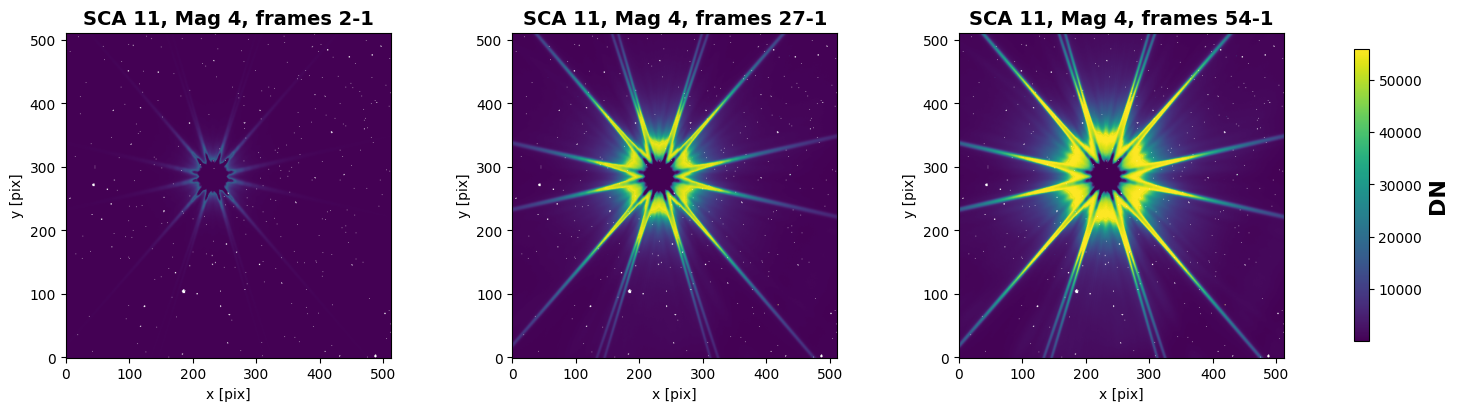

In [12]:
# Do another set of plots for the cutouts and set the flagged pixels to white
cmap = plt.cm.viridis.copy()
cmap.set_bad(color="white")

# Compute diffs and per-frame percentiles over good pixels only
diffs_masked, vmins, vmaxs = [], [], []
for nframe in frames:
    d = dm_cube_cutout[nframe] - dm_cube_cutout[baseline_frame]
    dm = np.ma.array(d, mask=bad)
    diffs_masked.append(dm)

    if good.any():
        vmin_i = np.percentile(d[good], 2)
        vmax_i = np.percentile(d[good], 98)
    else:
        # if everything is masked
        vmin_i, vmax_i = np.min(d), np.max(d)
    vmins.append(vmin_i); vmaxs.append(vmax_i)
    print(f"frame {nframe}: 2nd={vmin_i:.3g}, 98th={vmax_i:.3g}")

# Shared limits across panels
vmin, vmax = min(vmins), max(vmaxs)

# Plot side-by-side with one shared colorbar
fig, axes = plt.subplots(1, len(frames), figsize=(5*len(frames), 4), constrained_layout=True)
if len(frames) == 1:
    axes = [axes]

im = None
for ax, nframe, dm in zip(axes, frames, diffs_masked):
    im = ax.imshow(dm, vmin=vmin, vmax=vmax, cmap=cmap, origin="lower")
    ax.set_title(f"SCA {SCA}, Mag {Mag}, frames {nframe}-1", fontweight="bold", fontsize=14)
    ax.set_xlabel("x [pix]"); ax.set_ylabel("y [pix]")

cbar = fig.colorbar(im, ax=axes, shrink=0.9)
cbar.set_label("DN", fontweight="bold", fontsize=16)
plt.show()

## Pixel-Level Diagnostics: Saturation and Relative Slope
In the following section, we will identify saturated (and neighboring) pixels using the per-pixel DN limits and then visualize how each frame's instantaneous slope deviates from the average slope.

In [13]:
# Read the saturation thresholds (DN) from the reference file
sat_path = os.path.expanduser("~/crds_cache/references/roman/wfi/roman_wfi_saturation_0030.asdf")
print(sat_path)

with SaturationRefModel(sat_path) as satref:
    # 4096 x 4096 array thresholds in DN
    sat_dn = np.asarray(satref.data)

/home/runner/crds_cache/references/roman/wfi/roman_wfi_saturation_0030.asdf


In [14]:
# Functions to identify saturation
def _align_sat_dn(sat_dn, frames_hw):
    """
    Make sat_dn match the shape of the data cube
    If sat_dn is 4096x4096 and frames are 4088x4088 (no ref pixels),
    crop 4 pixels off each edge.
    """
    H, W = frames_hw
    sh, sw = sat_dn.shape
    if (sh, sw) == (H, W):
        return sat_dn
    if (sh - H == 8) and (sw - W == 8):
        # trim reference pixels: center-crop by 4 on each side
        return sat_dn[4:-4, 4:-4]
    raise ValueError(f"sat_dn shape {sat_dn.shape} does not match frames {(H, W)}")

def make_saturation_mask_dn(frames_dn, sat_dn):
    """
    DN-based saturation masks using a per-pixel DN threshold.

    Parameters
    ----------
    frames_dn : (N, H, W) float/uint array
        Non-destructive-read frames in DN.
    sat_dn : (H, W) float array
        Per-pixel saturation limits in DN. NaNs are treated as 'no check' (never saturate).

    Returns
    -------
    sat_mask        : (N, H, W) bool  -- pixels >= sat_dn in each frame
    nearby_sat_mask : (N, H, W) bool  -- 4-connected neighbors of saturated pixels (excluding the saturated ones)
    new_sat_mask    : (N, H, W) bool  -- pixels that become saturated in current frame (unsat in prev)
    diag_sat_mask   : (N, H, W) bool  -- diagonal neighbors (excluding sat + nearby)
    """
    assert frames_dn.ndim == 3, "frames_dn must be (N,H,W)"
    N, H, W = frames_dn.shape

    # Align and sanitize sat_dn
    sat_dn_use = _align_sat_dn(np.asarray(sat_dn), (H, W))
    
    # Treat NaN thresholds as never saturating
    sat_dn_use = np.where(np.isfinite(sat_dn_use), sat_dn_use, np.inf).astype(frames_dn.dtype, copy=False)

    # Core saturation check
    sat_mask = frames_dn >= sat_dn_use  # (N,H,W) bool

    # Neighborhood kernels (no center in 4-neighborhood kernel)
    kernel_4 = np.array([[0,1,0],
                         [1,0,1],
                         [0,1,0]], dtype=np.uint8)
    kernel_diag = np.array([[1,0,1],
                            [0,0,0],
                            [1,0,1]], dtype=np.uint8)

    nearby_sat_mask = np.zeros_like(sat_mask, dtype=bool)
    diag_sat_mask   = np.zeros_like(sat_mask, dtype=bool)
    new_sat_mask    = np.zeros_like(sat_mask, dtype=bool)

    for i in range(N):
        s = sat_mask[i]

        # Convolve boolean as uint8 to count neighboring saturated pixels
        conv4  = convolve2d(s.astype(np.uint8), kernel_4,  mode='same', boundary='fill', fillvalue=0) > 0
        convdg = convolve2d(s.astype(np.uint8), kernel_diag, mode='same', boundary='fill', fillvalue=0) > 0

        # neighbors that are not themselves saturated
        nearby_sat_mask[i] = (~s) & conv4
        # diagonal neighbors that are neither saturated nor 4-neighbors
        diag_sat_mask[i]   = (~s) & (~nearby_sat_mask[i]) & convdg

        # newly saturated in this frame (unsaturated previously)
        if i == 0:
            new_sat_mask[i] = s
        else:
            new_sat_mask[i] = s & (~sat_mask[i-1])

    return sat_mask, nearby_sat_mask, new_sat_mask, diag_sat_mask


def make_mean_debiased_difference_image_dn(frames_dn, raw_frames_dn, sat_dn):
    """
    Compute the mean over time of frame-to-frame differences (DN) while excluding
    saturated pixels and their 4-neighbors based on per-pixel DN limits.

    Parameters
    ----------
    frames_dn     : (N,H,W) array in DN
        Pre-processed frames (e.g., bias-subtracted) used to compute differences.
    raw_frames_dn : (N,H,W) array in DN
        Raw (or minimally processed) frames aligned with `frames_dn` used for saturation masking.
    sat_dn        : (H,W) array in DN
        Per-pixel saturation limits in DN.

    Returns
    -------
    mean_diff_frame : (H,W) float32 array
        Mean of diffs along time, excluding saturated + nearby pixels.
        NaN where no valid samples remain.
    """
    assert frames_dn.shape == raw_frames_dn.shape, "frames_dn and raw_frames_dn must align (N,H,W)"
    # Differences along time axis
    frame_diffs = np.diff(frames_dn, axis=0)  # shape (N-1,H,W)

    # Build masks from the raw data (DN)
    sat_mask, nearby_mask, _, _ = make_saturation_mask_dn(raw_frames_dn, sat_dn)
    # Align mask count with diffs (diffs start at frame 1)
    valid = ~(sat_mask[1:] | nearby_mask[1:])  # (N-1,H,W) bool

    # Weighted mean with binary weights; safe against zero-division
    w = valid.astype(np.float32)
    num = (frame_diffs * w).sum(axis=0, dtype=np.float64)
    den = w.sum(axis=0, dtype=np.float64)

    mean_diff_frame = np.divide(
        num, den,
        out=np.full(den.shape, np.nan, dtype=np.float32),
        where=den > 0
    ).astype(np.float32, copy=False)

    return mean_diff_frame

In [15]:
# Make a cutout for the saturation array to match the earlier raw and calibrated cutouts
sat_dn_cutout = sat_dn[row_0-q1:row_0+q1, col_0-q2:col_0+q2]

# Calculate the Mean slope image
mean_slope_image = make_mean_debiased_difference_image_dn(dm_cube_cutout, raw_cube_cutout, sat_dn_cutout)

# Get the 3D saturation mask
sat_mask, nearby_sat_mask, new_sat_mask, diag_mask= make_saturation_mask_dn(raw_cube_cutout, sat_dn_cutout)

# Get the difference images (AKA the instantaneous slope)
difference_images = np.diff(dm_cube_cutout, axis=0)                                                 

### Final visualizations of saturation and slope deviations
For each of the three representative frames (the 3rd, the middle, and the last), we will plot the following:
- **Left**: the raw image for that frame (scaled by $10^3$ for display).
- **Center**: a relative slope map defined as (difference_images[i-1] / mean_diff) to highlight pixels whose per-frame change deviates from the average slope. Note that saturation and nonlinear effects can push values below 1.
- **Right**: visualization of the combined mask encoding saturated/nearby/corrupted pixels via a weighted sum.
We see trends in these plotted quantities as the exposure time progresses.

Plotting frames: [2, 27, 54]


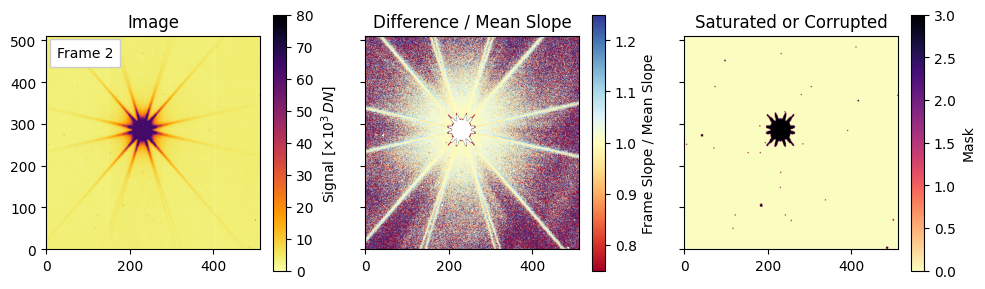

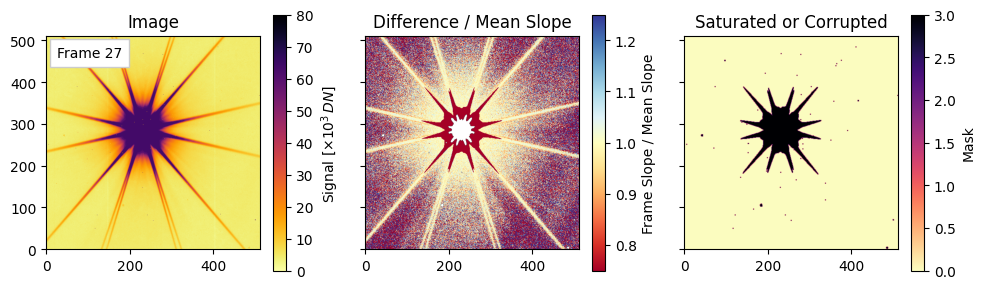

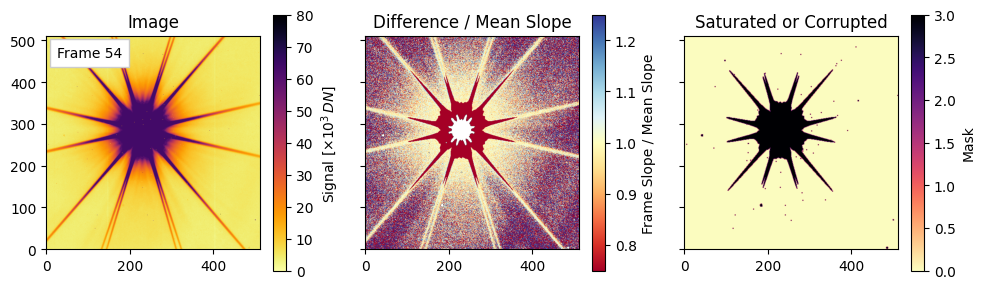

In [16]:
# Number of frames
N = len(dm_cube_cutout)

# Choose three frames: first usable (2), middle, and last
frames_to_plot = sorted({2, max(2, N//2), N-1})
print("Plotting frames:", frames_to_plot)

for i in frames_to_plot:
    if i < 2 or i >= N:
        continue

    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)

    # Left: current frame signal (rescale to ~same range as the original)
    cax1 = axes[0].imshow(dm_cube_cutout[i] / 1e3, cmap='inferno_r', origin='lower', vmin=0, vmax=80)
    cbar1 = plt.colorbar(cax1, ax=axes[0], label='Signal [$\\times 10^3\\, DN$]')

    # Center: difference / mean slope (robust to zeros/NaNs)
    ratio = np.divide(
        difference_images[i-1], # assumes difference_images is length N-1
        mean_slope_image,
        out=np.full_like(difference_images[i-1], np.nan, dtype=np.float32),
        where=np.isfinite(mean_slope_image) & (mean_slope_image != 0)
    )
    cax2 = axes[1].imshow(ratio, cmap='RdYlBu', vmin=0.75, vmax=1.25, origin='lower')
    cbar2 = plt.colorbar(cax2, ax=axes[1], label='Frame Slope / Mean Slope')

    # Right: masks (saturated, nearby saturated, corrupted)
    cax3 = axes[2].imshow(sat_mask[i]*3. + nearby_sat_mask[i]*2 + diag_mask[i], origin='lower', cmap='magma_r')
    cbar3 = plt.colorbar(cax3, ax=axes[2], label='Mask')
    
    # Titles & annotation
    axes[0].set_title('Image')
    axes[1].set_title('Difference / Mean Slope')
    axes[2].set_title('Saturated or Corrupted')

    axes[0].text(
        0.05, 0.95, f'Frame {i}', ha='left', va='top', transform=axes[0].transAxes,
        bbox=dict(facecolor='w', edgecolor='0.8', pad=5.0)
    )

    # Zoom window settings
    #for ax in axes:
    #    ax.set_xlim(6, 36)
    #    ax.set_ylim(6, 36)

    plt.tight_layout()
    plt.show()

## Additional Resources
- [Schlieder et al. 2024](https://ui.adsabs.harvard.edu/abs/2024SPIE13092E..0SS/abstract)
- [TVAC2 Bright Star Saturation Test Summary](https://asd.gsfc.nasa.gov/roman/WFI_Bright_Star/TVAC2_Bright_star_saturation_summary_release.pdf)
- [romancal](https://roman-pipeline.readthedocs.io/en/latest/index.html)
- [Roman Documentation](https://roman-docs.stsci.edu)

***

## About this Notebook
**Author:** Dana Louie, Robby Wilson, Ami Choi\
**Updated On:** 2025-09-29

<table width="100%" style="border:none; border-collapse:collapse;">
  <tr style="border:none;">
    <td style="border:none; width:180px; white-space:nowrap;">
       <a href="#top" style="text-decoration:none; color:#0066cc;">↑ Top of page</a> 
    </td>
    <td style="border:none; text-align:center;">
       <img src="../../roman_logo.png" width="50">
    </td>
    <td style="border:none; text-align:right;">
       <img src="../../stsci_logo2.png" width="90">
    </td>
  </tr>
</table>